# Baumgarte - Numerical Relativity
## Problem 4.6

In [1]:
from sympy import *
init_printing(use_unicode=True)

In [3]:
r, theta, phi = symbols('r, \\theta, \phi')
M, C = symbols('M, C')
coords = [ r, theta, phi ]

In [8]:
f0 = 1 - 2 * M / r
f0hs = C / sqrt(f0 * r ** 4 + C ** 2)

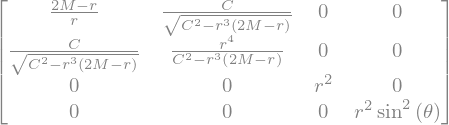

In [9]:
metric = Matrix([
    [ -f0, f0hs, 0, 0 ],
    [ f0hs, 1 / f0 * (1 - f0hs ** 2), 0, 0 ],
    [ 0, 0, r ** 2, 0 ],
    [ 0, 0, 0, r ** 2 * sin(theta) ** 2 ],
]).applyfunc(simplify)
metric

In [28]:
def compute_christoffel(metric):
    if metric.shape != (3, 3):
        raise Exception("Invalid dimensions")

    inv_metric = metric.inv()
    
    out = []
    for i in range(0, 3):
        rows = []
        for j in range(0, 3):
            row = []
            for k in range(0, 3):
                res = 0.0
                for l in range(0, 3):
                    res += inv_metric[i, l] * (
                        Derivative(metric[l, j], coords[k]) +
                        Derivative(metric[l, k], coords[j]) -
                        Derivative(metric[j, k], coords[l]))
                row.append(res / 2)
            rows.append(row)
        out.append(Matrix(rows).applyfunc(simplify))
    return out

def compute_ricci(christoffel):
    if len(christoffel) != 3 or christoffel[0].shape != (3, 3):
        raise Exception("Invalid dimensions")
    rows = []
    for i in range(0, 3):
        row = []
        for j in range(0, 3):
            res = 0.0
            for k in range(0, 3):
                res += Derivative(christoffel[k][i, j], coords[k])
                res -= Derivative(christoffel[k][k, j], coords[i])
                for l in range(0, 3):
                    res += christoffel[k][i, j] * christoffel[l][k, l]
                    res -= christoffel[k][i, l] * christoffel[l][j, k]
            row.append(res)
        rows.append(row)
    return Matrix(rows).applyfunc(simplify)

def compute_trace(matrix_lo, inv_metric):
    return simplify(matrix_lo[0, 0] * inv_metric[0, 0] +
                    matrix_lo[1, 1] * inv_metric[1, 1] +
                    matrix_lo[2, 2] * inv_metric[2, 2])

# Compute covariant derivative of rank-0 tensor
def compute_diff_scalar(s, christoffel):
    if len(christoffel) != 3:
        raise Exception('Invalid dimensions')

    return Matrix([ diff(s, x) for x in coords ]).applyfunc(simplify)

# Compute covariant derivative of rank-1 covariant tensor
def compute_diff_vec_lo(t, christoffel):
    if len(t) != 3 or len(christoffel) != 3:
        raise Exception('Invalid dimensions')

    rows = []
    for i in range(0, 3):
        row = []
        for j in range(0, 3):
            res = diff(t[i], coords[j])
            for k in range(0, 3):
                res -= christoffel[k][i, j] * t[k]
            row.append(res)
        rows.append(row)
    return Matrix(rows).applyfunc(simplify)

# Compute covariant derivative of rank-2 covariant tensor
def compute_diff_matrix_lo(m, christoffel):
    if m.shape != (3, 3) or len(christoffel) != 3:
        raise Exception('Invalid dimensions')

    out = []
    for i in range(0, 3):
        rows = []
        for j in range(0, 3):
            row = []
            for k in range(0, 3):
                res = diff(m[j, k], coords[i])
                for l in range(0, 3):
                    res -= christoffel[l][i, j] * m[l, k]
                    res -= christoffel[l][i, k] * m[j, l]
                row.append(res)
            rows.append(row)
        out.append(Matrix(rows).applyfunc(simplify))
    return out

def compute_laplacian(scalar, metric):
    christoffel = compute_christoffel(metric)
    vec_lo = compute_diff_scalar(scalar, christoffel)
    twoform = compute_diff_vec_lo(vec_lo, christoffel)
    return compute_trace(twoform, metric.inv())

# Compute lapse, shift, and K
def compute_factors(metric_full):
    metric_spat = metric_full[1:, 1:]
    inv_metric_full = metric_full.inv()
    
    alpha = (1 / sqrt(-inv_metric_full[0, 0].simplify())).simplify()
    beta_hi = (inv_metric_full[0, 1:] * (alpha ** 2)).applyfunc(simplify)
    beta_lo = metric_full[0, 1:]
    
    inv_metric_spat = inv_metric_full[1:, 1:] + (1 / alpha ** 2) * Matrix([
        [ beta_hi[i] * beta_hi[j] for i in range(0, 3) ]
        for j in range(0, 3)
    ])
    christoffel = compute_christoffel(metric_spat)
    
    diff_beta_lo = compute_diff_vec_lo(beta_lo, christoffel)
    K_lo = Matrix([
        [ diff_beta_lo[i, j] + diff_beta_lo[j, i] for j in range(0, 3) ]
        for i in range(0, 3)
    ])
    K_lo /= (2 * alpha)
    K_lo = K_lo.applyfunc(simplify)
    
    K_hi = inv_metric_spat * K_lo * inv_metric_spat.T
    
    KK = Trace(K_lo * K_hi)
    K = Trace(K_lo * inv_metric_spat).simplify()
    
    ricci = compute_ricci(christoffel)
    R = Trace(ricci * inv_metric_spat).simplify()

    return {
        'alpha': alpha,
        'beta_hi': beta_hi,
        'beta_lo': beta_lo,
        'K_lo': K_lo,
        'K_hi': K_hi,
        'KK': KK.simplify(),
        'K': K,
        
        'christoffel': christoffel,
        
        'metric_spat': metric_spat,
        'inv_metric_spat': inv_metric_spat.applyfunc(simplify),
        
        'ricci': ricci,
        'R': R,
    }

def compute_ham_constraint(factors):
    return factors['R'] + factors['K'] ** 2 - factors['KK']

def compute_mom_constraint(factors):
    dK_lo = compute_diff_matrix_lo(factors['K_lo'], factors['christoffel'])
    # Contract
    t = []
    for i in range(0, 3):
        res = 0
        for j in range(0, 3):
            for k in range(0, 3):
                res += factors['inv_metric_spat'][j, k] * dK_lo[j][i, k]
        t.append(res.simplify() - diff(factors['K'], coords[i]))
    return t

In [11]:
factors = compute_factors(metric)

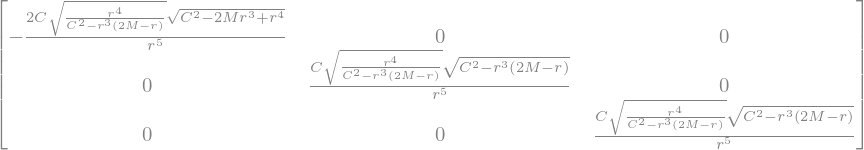

In [27]:
(factors['inv_metric_spat'] * factors['K_lo']).applyfunc(simplify)

In [30]:
compute_ham_constraint(factors).simplify()

In [33]:
[ x.simplify() for x in compute_mom_constraint(factors) ]